Graph characterization
===



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime
import bisect

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import networkx as nx

In [3]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_initiations"
assert os.path.exists(working_dir)

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [5]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
subset_start_date = datetime.fromisoformat('2014-01-01')
subset_start_timestamp = int(subset_start_date.timestamp() * 1000)

### Read in the data

In [6]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [7]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [8]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:14.230355


15850052

In [9]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
# note that only 41 updates have this issue
invalid_created_at = journal_df.created_at <= 0
journal_df.loc[invalid_created_at, 'created_at'] = journal_df.loc[invalid_created_at, 'updated_at']

In [10]:
# read the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

In [11]:
# read the user->user interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

14812407

In [12]:
# read the site-level metadata
site_metadata_working_dir = "/home/srivbane/shared/caringbridge/data/derived/site_metadata"
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_metadata_df = pd.read_feather(site_metadata_filepath)
len(site_metadata_df)

840943

In [13]:
# read in the interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
ints_df = pd.read_hdf(author_to_site)
len(ints_df)

28388948

### Filter the u2u links

In [14]:
valid_u2u_df = u2u_df[(u2u_df.from_user_id.isin(valid_user_ids))&(u2u_df.to_user_id.isin(valid_user_ids))]
len(valid_u2u_df), len(valid_u2u_df) / len(u2u_df)

(10441676, 0.704927700136784)

In [15]:
inits_df = valid_u2u_df.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')
len(inits_df), len(inits_df) / len(u2u_df)

(947270, 0.06395111881546328)

In [16]:
valid_ints_df = ints_df[ints_df.user_id.isin(valid_user_ids)]
len(valid_ints_df), len(valid_ints_df) / len(ints_df)

(25176609, 0.8868454371750584)

In [17]:
model_start_date = datetime.fromisoformat('2014-01-01')
model_start_timestamp = int(model_start_date.timestamp() * 1000)
model_end_date = datetime.fromisoformat('2016-01-01')
model_end_timestamp = int(model_end_date.timestamp() * 1000)

### Build the graph at a specified time

In [18]:
target_timestamp = end_timestamp

In [19]:
inits_subset = inits_df[inits_df.created_at < target_timestamp]
len(inits_subset)

917285

In [20]:
s = datetime.now()
base_graph = nx.DiGraph()
nodes = set(inits_subset.from_user_id) | set(inits_subset.to_user_id)
edges = [tuple(row) for row in inits_subset[["from_user_id", "to_user_id"]].values]
base_graph.add_nodes_from(nodes)
base_graph.add_edges_from(edges)
print(f"{datetime.now() - s}")

0:00:08.182485


In [21]:
G = base_graph

In [22]:
# compute users active at target_timestamp
# active users who have interacted within some threshold
threshold = int(1000 * 60 * 60 * 24 * (364 / 2))  # about 6 months
active_users = set(ints_df[(ints_df.created_at >= target_timestamp - threshold)&(ints_df.created_at <= target_timestamp)&(ints_df.user_id.isin(valid_user_ids))].user_id)
len(active_users), len(active_users) / len(valid_user_ids)

(66768, 0.18426637596765513)

In [110]:
364 / 2

182.0

In [23]:
isolate_count = 0
no_outdegree_count = 0
no_indegree_count = 0
for active_user in active_users:
    if active_user not in G.nodes:
        no_outdegree_count += 1
        no_indegree_count += 1
        isolate_count += 1
        continue
    if G.out_degree(active_user) == 0:
        no_outdegree_count += 1
    if G.in_degree(active_user) == 0:
        no_indegree_count += 1
    if G.out_degree(active_user) == 0 and G.in_degree(active_user) == 0:
        isolate_count += 1

In [24]:
np.max(np.array(G.in_degree())[:,1]), np.max(np.array(G.out_degree())[:,1])

(1632, 5440)

In [25]:
isolate_count / len(active_users),\
no_indegree_count / len(active_users),\
no_outdegree_count / len(active_users)

(0.17298705966930267, 0.3199436855978912, 0.3048316558830578)

In [26]:
sccs = nx.strongly_connected_components(G)
lscc = max(sccs, key=len)
second_largest_size = sorted(map(len, nx.strongly_connected_components(G)))[-2]
len(lscc), second_largest_size

(101897, 11)

In [27]:
wccs = nx.weakly_connected_components(G)
lwcc = max(wccs, key=len)
second_largest_size = sorted(map(len, nx.weakly_connected_components(G)))[-2]
len(lwcc), second_largest_size

(247576, 12)

In [28]:
G_active = G.subgraph(active_users)
len(G_active), len(G)

(55218, 261644)

In [29]:
np.max(np.array(G_active.in_degree())[:,1]), np.max(np.array(G_active.out_degree())[:,1])

(611, 1352)

In [30]:
wccs = nx.weakly_connected_components(G_active)
lwcc = max(wccs, key=len)
second_largest_size = sorted(map(len, nx.weakly_connected_components(G_active)))[-2]
len(lwcc), second_largest_size

(44898, 18)

In [31]:
sccs = nx.strongly_connected_components(G_active)
lscc = max(sccs, key=len)
second_largest_size = sorted(map(len, nx.strongly_connected_components(G_active)))[-2]
len(lscc), second_largest_size

(17042, 14)

In [165]:
# warning: SLOW
s = datetime.now()
diam = nx.diameter(G_active.subgraph(lscc))
print(f"{datetime.now() - s}")
diam

1:42:44.158828


38

In [109]:
G_active.number_of_edges()

145733

In [108]:
# compute number of dyads in G_active (and number of authors in dyads)
G_recip = G_active.to_undirected(reciprocal=True)
authors_in_dyads = sum([degree > 0 for node, degree in G_recip.degree()])
total_dyads = G_recip.number_of_edges()
authors_in_dyads, total_dyads

(20219, 21910)

In [32]:
# number of SCCs and WCCs
g = G_active
scc_sizes = np.array(list(map(len, nx.strongly_connected_components(g))))
scc_sizes = scc_sizes[scc_sizes > 1]
wcc_sizes = np.array(list(map(len, nx.weakly_connected_components(g))))
wcc_sizes = wcc_sizes[wcc_sizes > 1]
len(scc_sizes), len(wcc_sizes)

(2590, 2335)

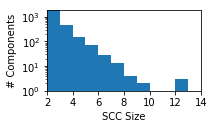

In [104]:
x = np.sort(scc_sizes)[:-1]
fig, ax = plt.subplots(1, 1, figsize=(5.47807 / 2, 1.6))
ax.hist(x, bins=12, log=False, align='mid')
ax.set_xlabel("SCC Size")
ax.set_ylabel("# Components")
plt.xticks(range(2, 16, 2))
#plt.yticks(np.logspace(start=0, stop=4, base=10, num=5))
import matplotlib.ticker as ticker
plt.yscale('log')
#ax.yaxis.set_major_locator(ticker.FixedLocator([0, 10, 10000]))
#ax.yaxis.set_minor_locator(ticker.NullLocator())
#ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'network_scc_dist_plot.pdf'), dpi=180, pad_inches=0)

plt.show()

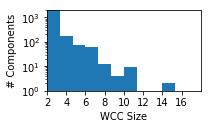

In [103]:
x = np.sort(wcc_sizes)[:-1]
fig, ax = plt.subplots(1, 1, figsize=(5.47807 / 2, 1.6))
ax.hist(x, bins=12, log=True, align='mid')
ax.set_xlabel("WCC Size")
ax.set_ylabel("# Components")
plt.xticks(range(2, 18, 2))

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'network_wcc_dist_plot.pdf'), dpi=180, pad_inches=0)

plt.show()

In [35]:
bins = []
#bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 7:
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)
    month += 3
    if month >= 12:
        year += 1
        month = 1
len(bins)

46

We compute network features every three months during the year:
```
1 2 3 4 5 6 7 8 9 10 11 12
^     ^     ^      ^
```

In [36]:
threshold = int(1000 * 60 * 60 * 24 * (364 / 2))  # about 6 months

active_user_counts = []
lwcc_sizes = []
lscc_sizes  = []
isolate_counts = []
in_lwcc_counts = []
in_other_comp_counts = []
for target_timestamp in tqdm(bins):
    inits_subset = inits_df[inits_df.created_at <= target_timestamp]
    
    g = nx.DiGraph()
    nodes = set(inits_subset.from_user_id) | set(inits_subset.to_user_id)
    edges = [tuple(row) for row in inits_subset[["from_user_id", "to_user_id"]].values]
    base_graph.add_nodes_from(nodes)
    base_graph.add_edges_from(edges)
    
    active_users = set(valid_ints_df[(valid_ints_df.created_at >= target_timestamp - threshold)&(valid_ints_df.created_at <= target_timestamp)].user_id)
    g_active = G.subgraph(active_users)
    active_user_count = len(active_users)
    active_user_counts.append(active_user_count)
    
    # nodes that appear in the active users list but not in the graph are isolates
    isolate_count = len(active_users - g_active.nodes)
    
    wccs = nx.weakly_connected_components(g_active)
    lwcc = max(wccs, key=len)
    lwcc_sizes.append(len(lwcc))
    
    in_lwcc_count = 0
    in_other_comp_count = 0
    for active_user in g_active.nodes:
        if active_user in lwcc:
            in_lwcc_count += 1
        else:
            in_other_comp_count += 1
            
    isolate_counts.append(isolate_count)
    in_lwcc_counts.append(in_lwcc_count)
    in_other_comp_counts.append(in_other_comp_count)
    assert active_user_count == isolate_count + in_lwcc_count + in_other_comp_count
    
    sccs = nx.strongly_connected_components(g_active)
    lscc = max(sccs, key=len)
    lscc_sizes.append(len(lscc))
    
    

100%|██████████| 46/46 [04:42<00:00,  6.14s/it]


In [37]:
active_user_counts = np.array(active_user_counts)
isolate_pcts = np.array(isolate_counts) / active_user_counts
in_lwcc_pcts = np.array(in_lwcc_counts) / active_user_counts
in_other_comp_pcts = np.array(in_other_comp_counts) / active_user_counts

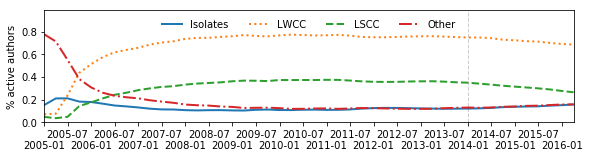

(0.15654726068633354,
 0.6859422034918724,
 0.2645996387718242,
 0.1575105358217941)

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,2))

plt.plot(bins, isolate_pcts, linestyle='solid', linewidth=2, label='Isolates')
plt.plot(bins, in_lwcc_pcts, linestyle='dotted', linewidth=2, label='LWCC')
plt.plot(bins, np.array(lscc_sizes) / active_user_counts, linestyle='dashed', linewidth=2, label='LSCC')
plt.plot(bins, in_other_comp_pcts, linestyle='dashdot', linewidth=2, label='Other')



plt.axvline(subset_start_timestamp, color='black', alpha=0.2, linestyle='--', linewidth=1)

plt.legend(ncol=4, frameon=False, loc=9)
plt.ylim((0,0.99))

plt.ylabel("% active authors")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'network_summary_timeline_plot.pdf'), dpi=200, pad_inches=0)
     
plt.show()
     
isolate_pcts[-1], in_lwcc_pcts[-1], (np.array(lscc_sizes) / active_user_counts)[-1], in_other_comp_pcts[-1]

In [46]:
# range of active user counts during the analysis period
active_user_counts[np.array(bins) >= subset_start_timestamp]

array([79695, 80855, 79059, 76139, 73467, 73532, 72326, 69811, 66714,
       66440])

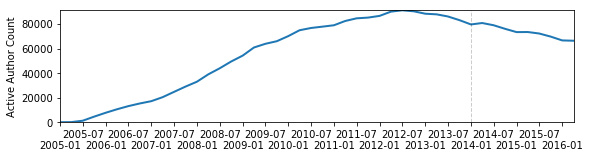

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,2))

plt.plot(bins, active_user_counts, linestyle='-', linewidth=2, label='Active Authors')
#plt.plot(bins, lwcc_sizes, linestyle='-', linewidth=2, label='LWCC Size')
#plt.plot(bins, lscc_sizes, linestyle='-', linewidth=2, label='LSCC Size')

plt.axvline(subset_start_timestamp, color='black', alpha=0.2, linestyle='--', linewidth=1)

#plt.legend(ncol=2, frameon=False, loc=10)

plt.ylabel("Active Author Count")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'network_user_summary_timeline_plot.pdf'), dpi=200, pad_inches=0)
     
plt.show()

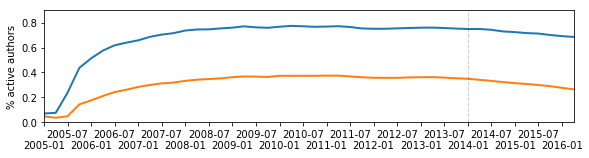

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,2))

#plt.plot(bins, isolate_pcts, linestyle='-', linewidth=2, label='Isolates')
plt.plot(bins, np.array(lwcc_sizes) / active_user_counts, linestyle='-', linewidth=2, label='LWCC %')
plt.plot(bins, np.array(lscc_sizes) / active_user_counts, linestyle='-', linewidth=2, label='LSCC Size')

plt.axvline(subset_start_timestamp, color='black', alpha=0.2, linestyle='--', linewidth=1)

#plt.legend(ncol=2, frameon=False, loc=10)
plt.ylim((0,0.9))

plt.ylabel("% active authors")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'network_wcc_vs_scc_timeline_plot.pdf'), dpi=200, pad_inches=0)
     
plt.show()

In [ ]:
#hist, bin_edges = np.histogram(initiations_df.created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Initiations')

In [144]:
n = 20000
s = 24
# sample n initiations
# using s negative samples
# valid candidate users are ALL valid authors who have posted their first update at this time
inits_subset = inits_df[(inits_df.created_at >= model_start_timestamp)&(inits_df.created_at <= model_end_timestamp)]
inits_subset = inits_subset.sample(n=n).sort_values(by='created_at', ascending=True)
inits_subset.head()

,from_user_id,to_user_id,created_at,int_type
13397423,22239537,5758186,1388556151000,amps
10668176,9825200,5749759,1388558061000,amps
14351032,27800665,8646149,1388558607000,amps
13827032,24273883,26728970,1388558755000,amps
11586580,13703620,22391773,1388564226000,amps


In [145]:
user_df['time_to_first_update'] = user_df.first_update - model_start_timestamp
# if first update is positive, it is still in the future
# if first update is <= 0, then it should already be an eligible node
# however, it might not be in the network, since the base network only contains connected nodes
active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
len(active_user_ids) / len(user_df)

0.7502187142088341

In [146]:
# create data structures storing all of the edges that do not yet but will exist in the model
# these will be added incrementally as computation continues
model_subset = inits_df[(inits_df.created_at >= model_start_timestamp)&(inits_df.created_at <= model_end_timestamp)]
all_edges = [(created_at, tuple(row))
             for created_at, row 
             in zip(model_subset.created_at, model_subset[["from_user_id", "to_user_id"]].values)]
edge_df = pd.DataFrame(all_edges, columns=['created_at', 'edge'])
edge_df['time_to_existence'] = edge_df.created_at - model_start_timestamp
# if time_to_existence <= 0, it should exist in the network
assert np.all(edge_df.time_to_existence > 0)
len(edge_df)

155141

In [ ]:
prev_timestep = model_start_timestamp
active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
sampled_initiations = []
for from_user_id, to_user_id, created_at in tqdm(zip(inits_subset.from_user_id, inits_subset.to_user_id, inits_subset.created_at), total=len(inits_subset)):
    curr_timestep = created_at
    elapsed_time = curr_timestep - prev_timestep
    if elapsed_time > 0:  # if 2+ sampled initiations occur at the same time, elapsed_time == 0
        # update the active users set
        user_df.time_to_first_update -= elapsed_time
        active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
        # update the graph with all initiations between previous timestep and now
        edge_df.time_to_existence -= elapsed_time
        new_edge_mask = edge_df.time_to_existence < 0  # edges that exist AT zero happen at the current timestep, including the edge from_user_id, to_user_id
        new_edges = edge_df[new_edge_mask]
        edge_df = edge_df[~new_edge_mask] # TODO Use loc for assignment?
        #assert np.all(edge_df[edge_df.time_to_existence==0].created_at == created_at)
        G.add_edges_from(new_edges.edge)
        # also add edges to the WCC graph
        for from_user_id, to_user_id in new_edges.edge:
            wcc_graph.add_edge(from_user_id, to_user_id)
    
    # candidate users are all active users...
    candidate_user_ids = set(active_user_ids)
    # ... minus the true initiation target...
    candidate_user_ids.discard(to_user_id)
    # ... minus users already initiated to by this user
    if from_user_id in G:
        candidate_user_ids -= set(G[from_user_id].keys())
    
    # we only sample s of the candidate users
    negative_sampled_users = list(random.sample(candidate_user_ids, s))
    
    # now, extract ids for the target user and all of the negative sampled users
    indegree_list = []
    outdegree_list = []
    is_reciprocal_list = []
    is_weakly_connected_list = []
    is_friend_of_friend_list = []
    #is_strongly_connected_list = []
    for user_id in [to_user_id] + negative_sampled_users:
        is_friend_of_friend = False
        if user_id in G:
            indegree = G.in_degree(user_id)
            outdegree = G.out_degree(user_id)
            is_reciprocal = from_user_id in G[user_id]
            is_weakly_connected = wcc_graph.are_weakly_connected(from_user_id, user_id)
            if is_weakly_connected:
                is_friend_of_friend = compute_is_friend_of_friend(G, from_user_id, user_id)
                #is_strongly_connected = are_strongly_connected(G, from_user_id, user_id)
        else:
            indegree = 0
            outdegree = 0
            is_reciprocal = False
            is_weakly_connected = False
        
        indegree_list.append(indegree)
        outdegree_list.append(outdegree)
        is_reciprocal_list.append(is_reciprocal)
        is_weakly_connected_list.append(is_weakly_connected)
        is_strongly_connected_list.append(is_strongly_connected)
        is_friend_of_friend_list.append(is_friend_of_friend)
    
    d = {
        'initiator_user_id': from_user_id,
        'target_user_id': to_user_id,
        'negative_user_ids': negative_sampled_users,
        'created_at': created_at,
        'indegree_list': indegree_list,
        'outdegree_list': outdegree_list,
        'is_reciprocal_list': is_reciprocal_list,
        'is_weakly_connected_list': is_weakly_connected_list,
        'is_friend_of_friend_list': is_friend_of_friend_list
    }
    sampled_initiations.append(d)
    
    prev_timestep = curr_timestep


In [148]:
sampled_inits_df = pd.DataFrame(sampled_initiations)
len(sampled_inits_df)

20000

In [149]:
# save the sampled initiations dataframe with graph features
# so that the expensive graph feature computation can be saved
sampled_inits_df_filename = "sampled_inits_df.pickle"
sampled_inits_df_filepath = os.path.join(working_dir, sampled_inits_df_filename)
sampled_inits_df.to_pickle(sampled_inits_df_filepath)
print("Finished.")

Finished.


In [39]:
# read the sampled initiations dataframe with graph features
sampled_inits_df_filename = "sampled_inits_df.pickle"
sampled_inits_df_filepath = os.path.join(working_dir, sampled_inits_df_filename)
sampled_inits_df = pd.read_pickle(sampled_inits_df_filepath)
len(sampled_inits_df)

20000

In [150]:
sampled_inits_df.head()

,initiator_user_id,target_user_id,negative_user_ids,created_at,indegree_list,outdegree_list,is_reciprocal_list,is_weakly_connected_list,is_friend_of_friend_list
0,22239537,5758186,"[370350, 6940380, 5863211, 21034677, 10553453,...",1388556151000,"[41, 1, 6, 9, 1, 0, 0, 0, 0, 0, 5, 5, 0, 0, 1,...","[10, 3, 1, 2, 1, 1, 0, 0, 0, 0, 6, 2, 0, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, False, False, F...","[False, False, False, False, False, False, Fal..."
1,8888130,1402976,"[2516543, 3937319, 8826219, 5807457, 2415107, ...",1388558061000,"[503, 9, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...","[371, 4, 1, 0, 5, 7, 1, 0, 0, 0, 0, 0, 3, 0, 1...","[False, False, False, False, False, False, Fal...","[True, True, True, False, True, True, True, Fa...","[True, False, False, False, False, False, Fals..."
2,4804553,5043364,"[1266249, 16971126, 6547604, 17128374, 111663,...",1388558607000,"[4, 7, 0, 1, 2, 3, 0, 0, 0, 0, 8, 2, 1, 1, 3, ...","[7, 3, 0, 6, 1, 3, 1, 1, 1, 1, 15, 3, 1, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, True, False, True, True, True, True, Tr...","[False, False, False, False, False, False, Fal..."
3,27800665,27795336,"[5214754, 18345673, 53400, 5393460, 4404141, 2...",1388558755000,"[1, 8, 6, 16, 4, 2, 0, 0, 1, 4, 3, 2, 0, 0, 0,...","[0, 10, 3, 4, 5, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, False, False, False, False, False, Fals...","[False, False, False, False, False, False, Fal..."
4,2574230,27751497,"[1461304, 14029150, 7396569, 2826403, 22936889...",1388564226000,"[4, 2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 1, 49, 0, 2,...","[0, 0, 1, 1, 0, 0, 5, 0, 0, 1, 3, 0, 16, 4, 0,...","[False, False, False, False, False, False, Fal...","[True, True, True, False, False, True, True, T...","[False, False, False, False, False, False, Fal..."


In [151]:
# dictionaries for computing user-level features
author_type_dict = {row.user_id: row.user_author_type for row in user_df.itertuples()}
health_condition_dict = {row.user_id: row.health_condition for row in user_df.itertuples()}
is_multisite_author_dict = {row.user_id: row.is_multisite_author for row in user_df.itertuples()}
is_mixedsite_author_dict = {row.user_id: row.is_mixedsite_author for row in user_df.itertuples()}
update_count_dict = {row.user_id: row.update_count for row in user_df.itertuples()}
update_frequency_dict = {row.user_id: row.update_frequency for row in user_df.itertuples()}

In [152]:
# compute days_since_most_recent_update
# given a target user_id and a created_at timestamp
def get_most_recent_update(user_id, created_at):
    update_times = user_updates_dict[user_id]
    # update_times is a sorted list of created_at times for all updates by the given user_id
    ind = bisect.bisect_right(update_times, created_at)
    most_recent_update = update_times[ind-1]
    return most_recent_update

def compute_days_since_most_recent_update(user_id, created_at):
    most_recent_update = get_most_recent_update(user_id, created_at)
    ms_since_most_recent_update = created_at - most_recent_update
    days_since_most_recent_update = ms_since_most_recent_update / (1000 * 60 * 60 * 24)
    return days_since_most_recent_update

def compute_days_since_first_update(user_id, created_at):
    update_times = user_updates_dict[user_id]
    ind = bisect.bisect_right(update_times, created_at)
    most_recent_update = update_times[ind-1]
    first_update = update_times[0]
    ms_since_first_update = most_recent_update - first_update
    days_since_first_update = ms_since_first_update / (1000 * 60 * 60 * 24)
    return days_since_first_update

In [ ]:
sampled_initiations_filename = "author_initiation_choices_train_20000.csv"
sampled_initiations_filepath = os.path.join(working_dir, sampled_initiations_filename)
with open(sampled_initiations_filepath, 'w') as outfile:
    header = """
            choice_id,
            initiator_user_id,
            candidate_user_id,
            is_target,
            target_outdegree,
            target_indegree,
            target_has_indegree,
            is_reciprocal,
            is_weakly_connected,
            is_friend_of_friend,
            is_author_type_shared,
            target_author_type,
            initiator_author_type,
            target_health_condition,
            is_health_condition_shared,
            target_is_multisite_author,
            target_is_mixedsite_author,
            target_update_count,
            target_update_frequency,
            target_days_since_most_recent_update,
            target_days_since_first_update,
            target_site_visits
    """
    header = re.sub(r'\s+', '', header).strip() + "\n"
    format_str = "iiiiiiiiiiiccciiiidddi"
    outfile.write(header)
    for i, row in tqdm(enumerate(sampled_inits_df.itertuples()), total=len(sampled_inits_df)):
        choice_id = i
        initiator_user_id = row.initiator_user_id
        initiator_author_type = author_type_dict[initiator_user_id]
        initiator_health_condition = health_condition_dict[initiator_user_id]
        for i, user_id in enumerate([row.target_user_id] + row.negative_user_ids):
            is_target = int(i == 0)
            candidate_user_id = user_id
            target_outdegree = row.outdegree_list[i]
            target_indegree = row.indegree_list[i]
            target_has_indegree = int(target_indegree > 0)
            is_reciprocal = int(row.is_reciprocal_list[i])
            is_weakly_connected = int(row.is_weakly_connected_list[i])
            is_friend_of_friend = int(row.is_friend_of_friend_list[i])
            
            # Include the user-level features for the candidates
            target_author_type = author_type_dict[candidate_user_id]
            is_author_type_shared = int(initiator_author_type == target_author_type)
            
            target_health_condition = health_condition_dict[candidate_user_id]
            is_health_condition_shared = int(initiator_health_condition == target_health_condition)
            
            target_is_multisite_author = int(is_multisite_author_dict[candidate_user_id])
            target_is_mixedsite_author = int(is_mixedsite_author_dict[candidate_user_id])
            target_update_count = update_count_dict[candidate_user_id]
            target_update_frequency = update_frequency_dict[candidate_user_id]
            
            target_days_since_most_recent_update = compute_days_since_most_recent_update(candidate_user_id, row.created_at)
            target_days_since_first_update = compute_days_since_first_update(candidate_user_id, row.created_at)
            
            target_site_visits = user_visits_dict[candidate_user_id]
            
            line_vars = [
                choice_id,
                initiator_user_id,
                candidate_user_id,
                is_target,
                target_outdegree,
                target_indegree,
                target_has_indegree,
                is_reciprocal,
                is_weakly_connected,
                is_friend_of_friend,
                is_author_type_shared,
                target_author_type,
                initiator_author_type,
                target_health_condition,
                is_health_condition_shared,
                target_is_multisite_author,
                target_is_mixedsite_author,
                target_update_count,
                target_update_frequency,
                target_days_since_most_recent_update,
                target_days_since_first_update,
                target_site_visits
            ]
            line = ",".join([str(v) for v in line_vars]) + "\n"
            #line = f"{choice_id},{initiator_user_id},{candidate_user_id},{is_target},{target_outdegree},{target_indegree},{target_has_indegree},{is_reciprocal},{is_author_type_shared},{target_author_type},{initiator_author_type}\n"
            outfile.write(line)
print(f"R column types format string: {format_str}")
sampled_initiations_filepath